This notebook contains the code used in the article, used to produce the plots of the neural network output. 
The neural network was trained in separate phases. Hence the parameters can be saved and pre-loaded as necessary.

In [ ]:
using Plots;
using Trapz;
using Distributions
using Interpolations;
using ForwardDiff; 
using DataFrames;
using CSV;
using ZChop;
using ImageFiltering;
using Flux;
using Flux: params, 
            Dense, 
            Chain, 
            glorot_normal, 
            normalise, 
            Optimiser,
            train!;
using StatsBase;
using JLD2;
using Random;
using Polynomials;



In [10]:
const global tau =  Int(1)
#const global beta = Float32(1)
const global L = Int(1)
const global m = Int(1)

const global T_initial = Int(0)
const global T_final = 0.2

const global epsilon = 1  #Float32(sqrt(tau^2/(m*beta*(L^2))))
const global beta = 1/epsilon 

###############

#location of peaks
const global peak_location = 1

###############

#space discretisation
global x_samples = 512 #number of sample points per batch
global p_samples = 512
global interval_start = -3
global interval_end = 3
global p_axis = collect(transpose(Float32.(Array(range(interval_start,interval_end,p_samples)))));


#intial and final distributions
###########
global function p_initial(y)

    return exp.(-((y.-peak_location).^4)/4)
end;


global function p_final(y)

    return exp.(-(((y.^2).-(peak_location^2)).^2)/4);
end;


global function normalisation(y)
    
    return replace(y ./ abs(trapz(vec(p_axis),vec(abs.(y)))),NaN=>0)
end


#initialise value function
global function v_final(y)
    
    return  -y .^2
    #exp.(0 .*y)
end
###############

#u initial drift
global function u_initial(q)     
    return -log.(p_initial(q))
     
end;


#calculate normalisation for distributions
int_range = Array(range(-8,8,8000))
norm_range = Array(range(-8,8,8000))

global normfinal = abs.(trapz(norm_range,p_final(norm_range)));
global norminitial = abs.(trapz(norm_range,p_initial(norm_range)));
global weights_pfinal = vec(p_final(int_range)) #/normfinal

global T = T_final;

#global delta = 0.001;

In [11]:
##define the time mesh##
time_interval = vec(unique(df_new.t))
global time_interval = round.(time_interval;digits = 4)

global time_grid = Int(length(time_interval));


global time_steps_vec = [round.(time_interval[Int(k+1)]-time_interval[Int(k)];digits =3) for k in 1:length(time_interval)-1];
global plot_times = time_interval[begin:4:end]; #these times are used in the plots

In [5]:
##filtering functions
function filtering(input_array,filter_delta)
    
    #= this function implements a simple box filter of size filter_delta and padds missing reults
    
    inputs: 
    input_array - array to be smooths
    filter_delta - size of filter, number of nearest neighbours to consider
    
    output:
    filtered array with borders filled with constant value. 
    =#
    
    return imfilter(vec(input_array),reflect((1/filter_delta).*centered(ones(filter_delta))),Pad(:replicate))
    
end;

In [7]:
#####
#DU is initialised as a neural net
#space dimensions 
d=1

#neurons = 20

#input dimension = d + time
#define network layers
input_learn = Dense(d+1, 10, swish; 
                       bias = true, 
                       init = Flux.glorot_normal())

hidden1_learn = Dense(10,4, swish;
                        bias = true,
                       init = Flux.glorot_normal())

#cubic initalisation on last layer? 
output_learn = Dense(4,1,identity; #cubic
                bias = true,
                init= Flux.glorot_uniform(gain = 10))


#define network architecture
du_iter_learn = Chain(input_learn,#Dropout(0.5),
                hidden1_learn,#Dropout(0.2),
                output_learn)#,Dropout(0.5))

#get parameters
ps_learn = Flux.params(du_iter_learn)


######
#training specifics
DUloss(m,u,v) = mean(((beta/2)*m(u) .- v).^2)# .+ sum(u.^2) #.+ (beta/4)*mean(rho .*du_iter(u).^2) 
kl_loss(u,rho) = (beta/4)*mean(rho .*du_iter(u).^2)

######



kl_loss (generic function with 1 method)

In [8]:
#####
#DU is initialised as a neural net
#space dimensions 
d=1

#input dimension = d + time
#define network layers
input = Dense(d+1, 10, swish; 
                       bias = true, 
                       init = Flux.glorot_normal())

hidden1 = Dense(10,4, swish;
                        bias = true,
                       init = Flux.glorot_normal())


#cubic initalisation on last layer? 
output = Dense(4,1,identity; #cubic
                bias = true,
                init= Flux.glorot_uniform(gain = 10))


#define network architecture
du_iter = Chain(input,#Dropout(0.5),
                hidden1,#Dropout(0.2),
                #hidden2,#Dropout(0.5),
                #hidden3,
                #hidden4,
                output)#,Dropout(0.5))

#get parameters
ps = Flux.params(du_iter)


######
#training specifics
DUloss(m,u,v) = mean(((beta/2)*m(u) .- v).^2)# .+ sum(u.^2) #.+ (beta/4)*mean(rho .*du_iter(u).^2) 
kl_loss(u,rho) = (beta/4)*mean(rho .*du_iter(u).^2)

######

kl_loss (generic function with 1 method)

In [10]:
l2_norm(u,v) = mean((u .-v).^2);

In [11]:
#Set up for the optimisers and learning schedules
#initialise a value function
#v_iter_fun_poly2 = Polynomials.fit(vec(p_axis), 0 .*vec(p_axis), 6); map(x -> round(x, digits=4), v_iter_fun_poly2)

#for the drift
eta = 0.001
learn_rate_decrease = 1000

eta_value = 0.1#0.0001
learn_rate_decrease = 1000

global gamma_value = 0.1;

# Initialise optimisers ExpDecay(η = 0.001,
du_optimiser = opt = Optimiser(ClipValue(1e-3), ADAM(eta))
du_opt_state = Flux.setup(opt, du_iter_learn)
du_opt_state_final = Flux.setup(opt, du_iter)
#v_optimiser = Momentum(eta_value, 0.9)
#value_opt_state =Flux.setup(v_optimiser, v_iter_fun);

update_steps_value = 1;

#initialise the functions

vtx = zeros(time_grid,x_samples) #values_t(x) (function of q) 
ptx = zeros(time_grid,x_samples); #p_t(x) (func of  q) 
dvtx = zeros(time_grid,x_samples); #p_t(x) (func of  q) 

#monte carlo samples
global mc_samples_dvtx = Int(10)
global mc_samples_ptx = Int(1000)

1000

In [12]:
#If you want to use a pretrained model ... 
#du_model_state = JLD2.load("filename.jld2", "du_model_state");

#Load trained models
#Flux.loadmodel!(du_iter, du_model_state);
#Flux.loadmodel!(du_iter_learn, du_model_state);

#v_iter_fun_poly2 = Polynomial([0.012501817,1.7759079, -0.98531216, 0.29115227, 0.16276835, -0.04258577,0.01356363])

In [ ]:
#Random.seed!(74)

train_steps = 20
#eta = 0.0000001
x_temp = zeros((1,x_samples))
p_temp = ones((1,x_samples))
v_temp = ones((1,x_samples))

update_steps = 100;

#save the errors 
loss_drift2::Array{Float32, 3} = zeros((time_grid,train_steps,update_steps))
loss_drift3::Array{Float32, 3} = zeros((time_grid,train_steps,update_steps))
loss_value4::Array{Float32, 2} = zeros((train_steps,update_steps_value))
loss_drift_fromknown2::Array{Float32, 3} = zeros((time_grid,train_steps,update_steps))
loss_l2::Vector = zeros(train_steps)

for l in 1:train_steps

    eta = 0.0001

    println("#####ITERATION ",l,"####")

    
    ###GET POINT CLOUDS
    initial_sampler::Uniform{Float32} = Uniform(interval_start,interval_end);
    x_init::Array{Float32,2} = rand(initial_sampler,(1,x_samples))
    x_0::Array{Float32,3} = repeat(x_init, outer = [1,1,mc_samples_dvtx])

    #compute final distribution on new coords
    p_final_vals::Array{Float32,2} = p_final(x_init) ./ normfinal #,digits=10)# .+ 1e-100

    ########VALUE FUNCTION#########

    for u in 1:update_steps_value

        #setup
        y_t = copy(repeat(x_init, outer = [1,1,mc_samples_ptx])) #initialise x_t
        girsanov_term::Array{Float32,3} = zeros((1,x_samples,mc_samples_ptx))  #cumulative term for girsanov weights

        #####COMPUTE DISTRIBUTION at t = T
        for i in 1:time_grid-1

            #sample a brownian motion
            currtime::Float32 = time_interval[time_grid-i+1]
            currdt::Float32 = abs(time_interval[time_grid-i] - currtime) #time_step

            #sample brownian noise: W_{i-1} - W_i 
            innovation::Array{Float32,3} = rand(Normal(0,1),(1,x_samples,mc_samples_ptx))

            #one step of reverse sde
            y_t .-= sqrt(2*currdt/beta).*innovation  #compute x_{t_{i-1}}
            x_data = cat(y_t,currtime.*ones((1,x_samples,mc_samples_ptx)),dims=1)
            currdrift = du_iter(x_data)  #get current drift

            girsanov_term .+= sqrt(beta*currdt/2).*innovation.*currdrift .+ currdt*(beta/4).*(currdrift.^2) #add to girsanov weight

        end

        ######

        p_vals::Array{Float32,2} = mean(exp.(-beta*u_initial(y_t).- girsanov_term)./ norminitial,dims=3)[:,:,1]
        p_temp = p_vals
        x_temp = x_init

        #########################################

        ##UPDATE VALUE FUNCTION##
        #get training data
        vfupdate::Matrix{Float32} = log.(p_vals./p_final_vals)

        #remove nans
        p_axisf = transpose([p for (p,v) in zip(vec(x_init), vec(vfupdate)) if !isnan(v) && !isinf(v) && !isinf(-v)])
        v_vecf = transpose([v for v in vec(vfupdate) if !isnan(v) && !isinf(v) && !isinf(-v)])

        v_vals::Matrix{Float32} = copy(v_iter_fun_poly2.(p_axisf) .+ eta_value*v_vecf)

        v_iter_fun_poly2 =  Polynomials.fit(vec(p_axisf), vec(v_vals), 6); map(x -> x, v_iter_fun_poly2)

        v_temp = v_iter_fun_poly2.(x_init)

        loss_value4[l,u] = mean(abs.(v_vals .- v_iter_fun_poly2.(p_axisf)))

    end

    println("Value function loss ",mean(loss_value4[l,:]))
    
    
    ####DRIFT########
    
    #Flux.trainmode!(du_iter)

    for u in 1:update_steps
        
        #set up the optimiser here for flexible schedule
        opt = Optimiser(ADAM(eta))
        du_opt_state = Flux.setup(opt, du_iter_learn)
        ####DRIFT########

        #compute evolutions of dvtx
        for t::Int in 1:time_grid-1

            #get current time
            #this is the time at which we compute the approximation
            curr_time::Float64 = time_interval[t]

            #for dvtx
            y_t = copy(repeat(x_init, outer = [1,1,mc_samples_dvtx]))

            girsanov_value::Array{Float64,3} = zeros((1,x_samples,mc_samples_dvtx))
            int_exp::Array{Float64,3} = zeros((1,x_samples,mc_samples_dvtx))  #store the integral
            int2::Array{Float64,3} = zeros((1,x_samples,mc_samples_dvtx))  #store the integral
            int_currddu::Array{Float64,3} = zeros((1,x_samples,mc_samples_dvtx))  #store the integral

            for i in t:time_grid-1

                #get current times from discretisation
                currtime::Float64 = time_interval[i]
                currdt::Float64 = abs(time_interval[i+1] - currtime)
                
                x_data = cat(y_t,currtime.*ones((1,x_samples,mc_samples_dvtx)),dims=1)

                #compute current drift
                currdu::Array{Float64,3} = du_iter(x_data)

                temp_grad = [Flux.gradient(x -> du_iter([x;currtime])[1],[y_t[i]])[1][] for i in 1:x_samples]    
                currddu = transpose(temp_grad) 

                
                #get update step 
                innovation::Array{Float64,3} = rand(Normal(0,1),(1,x_samples,mc_samples_dvtx))

                if i == t

                    int_currddu .+= sqrt(currdt)*innovation.*exp.(-int_exp)

                    int2 .+= currdt*int_currddu.*(currdu.^2) 

                    else #i>t
                    int_exp .+= currdt*currddu

                    int_currddu .+= sqrt(currdt)*exp.(-int_exp).*innovation

                    int2 .+= currdt*int_currddu.*(currdu.^2) ./ (currtime - curr_time) 


                end   

                #go forward one step
                y_t = y_t .- (currdu.*currdt) .+ sqrt(2*currdt/beta) .*innovation

            end

            #compute dv 
            vout::Array{Float32,3} = v_iter_fun_poly2.(y_t)

            dv_curr = sqrt(beta/2)*mean((vout.*int_currddu/(T-curr_time) + (beta/4)*int2),dims=3)[:,:,1]


            dvtx[t,:] = dv_curr

            #save it for plots 
            loss_drift2[t,l,u] = DUloss(du_iter,Float32.([x_init; curr_time.*ones((1,x_samples))]), dv_curr)

            grads = Flux.gradient(du_iter_learn) do m
                                  DUloss(m,Float32.([x_init; curr_time .*ones((1,x_samples))]),dv_curr)
                                    end
            Flux.update!(du_opt_state, du_iter_learn, grads[1])
            
            loss_drift3[t,l,u] = DUloss(du_iter_learn,Float32.([x_init; curr_time.*ones((1,x_samples))]), dv_curr)

        end    
        

        dv_poly_temp = derivative(v_iter_fun_poly2)
        dv_end = dv_poly_temp.(x_init) #v_iter_fun_poly2(x_temp) #[Flux.gradient(x -> v_iter_fun_poly2(x)[1],[x_init[i]])[1][] for i in 1:x_samples]    
        dvtx[end,:] = dv_end
        x_end = Float32.([x_init; T.*ones((1,x_samples))])

        #update the loss function for each x
        grads = Flux.gradient(du_iter_learn) do m
                      DUloss(m,x_end,dv_end)
                end
        Flux.update!(du_opt_state, du_iter_learn, grads[1])

        
        loss_drift3[end,l,u] += DUloss(du_iter_learn, x_end, dv_end) #loss after param update

        #uupdate fixed du_iter params
        #du_model_state = Flux.state(du_iter_learn)
        #Flux.loadmodel!(du_iter, du_model_state);
        Flux.loadparams!(du_iter, ps_learn);


    end


    #Flux.testmode!(du_iter)

    #check how close we are to the saved solution
    #xnum = length(df_new.x)
    #xloss = reshape(df_new.x,(1,xnum))
    #tloss = reshape(df_new.t,(1,xnum))

    #loss_l2[l] = l2_norm(vec(du_iter_learn(Float32.([xloss; tloss]))),vec(-df_new.dutx))

    #########################################
    drift_mean_loss = mean(loss_drift3[:,l,:])
    

    println("Total drift loss at iteration ", l, " after training is ", mean(drift_mean_loss))
    #println("From knwon solution ", mean(loss_l2[l]))

        
end
    

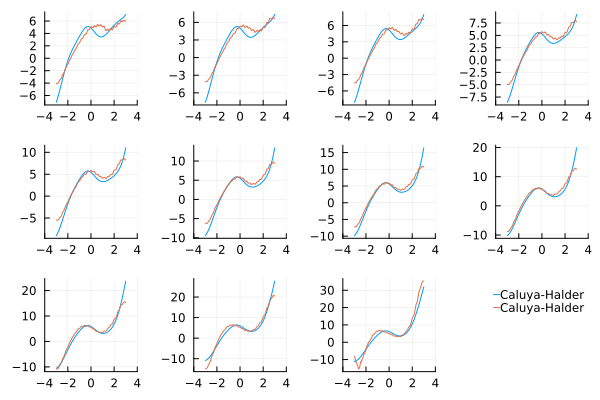

In [30]:
#plot the drifts

p2 = plot(layout = 12)

#evolve

for t in 1:11

    curr_time = plot_times[t]
    
    filtered_df = filter(row -> row.t == curr_time, df_new)

    plot!(vec(p_axis),vec(du_iter_learn(Float32.(([p_axis; curr_time.*ones(1,p_samples)])))),subplot=t)

    fun_temp = linear_interpolation(vec(filtered_df.x),vec(filtered_df.sigma),extrapolation_bc = Line())
    du = filtering(ForwardDiff.derivative.(Ref(fun_temp), vec(p_axis)),60) #this is \partial_q V_t
    
    plot!(p2,vec(p_axis),vec(du),subplot=t,label = "drift output")
    
end

#plot!(p2,ylim =(-15,15))

#scatter!(p2,vec(x_plot),vec(dvtx[end,:]),subplot=11)


plot!(p2,xlim =(-4,4))
plot!(p2,legend = false)
plot!(p2,[],[],framestyle = :none,legend = true,labels = "Neural Network", subplot = 12)
plot!(p2,[],[],framestyle = :none,legend = true,labels = "Caluya-Halder", subplot = 12,fg_legend = :false)
#plot!(vec(p_axis),vec(dv_iter_fun_temp(p_axis)),subplot=11)


plot(p2)

#savefig("od_dw_drifts_approx_val.png")

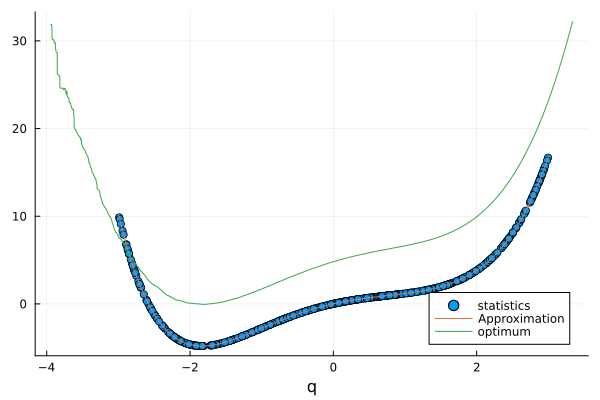

In [35]:
#plot the value function
filtered_df = filter(row -> row.t == T_final, df_new)

scatter(vec(x_temp),vec(v_temp),label="statistics")

plot!(vec(p_axis),vec(v_iter_fun_poly2.(p_axis)),label="Approximation")
plot!(filtered_df.x,(beta/2)*filtered_df.sigma,label="optimum")
xlabel!("q")


In [ ]:
#find the terminal distribution using the learned parameters 
mc_samples_ptx = 10000

#setup
y_t = copy(repeat(p_axis, outer = [1,1,mc_samples_ptx])) #initialise x_t
girsanov_term::Array{Float32,3} = zeros((1,x_samples,mc_samples_ptx))  #cumulative term for girsanov weights

#####COMPUTE DISTRIBUTION at t = T
for i in 1:time_grid-1

    #sample a brownian motion
    currtime::Float32 = time_interval[time_grid-i+1]
    currdt::Float32 = abs(time_interval[time_grid-i] - currtime) #time_step

    #sample brownian noise: W_{i-1} - W_i 
    innovation::Array{Float32,3} = rand(Normal(0,1),(1,x_samples,mc_samples_ptx))

    #one step of reverse sde
    y_t .-= sqrt(2*currdt/beta).*innovation  #compute x_{t_{i-1}}
    x_data = cat(y_t,currtime.*ones((1,x_samples,mc_samples_ptx)),dims=1)
    currdrift = du_iter(x_data)  #get current drift

    girsanov_term .+= sqrt(beta*currdt/2).*innovation.*currdrift .+ currdt*(beta/4).*(currdrift.^2) #add to girsanov weight

end

######

p_vals::Array{Float32,2} = mean(exp.(-beta*u_initial(y_t).- girsanov_term)./ norminitial,dims=3)[:,:,1]
p_temp = p_vals
#x_temp = x_init

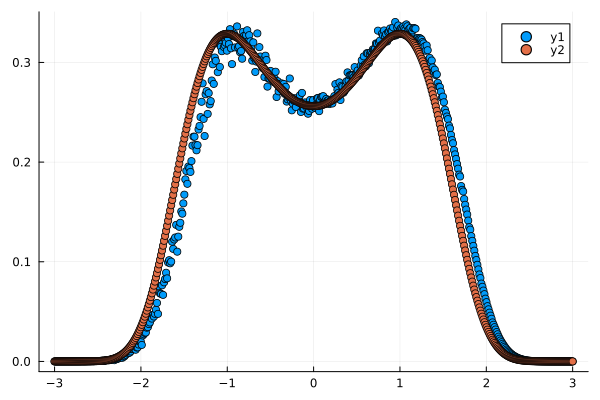

In [22]:
scatter(vec(p_axis),vec(p_temp))
scatter!(vec(p_axis),p_final(vec(p_axis))/normfinal)
